In [56]:
import torch
import torch.nn as nn
import torchvision as tv
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, Subset
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam, SGD
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Functions

In [22]:
class_name = lambda cls: str(cls).split("<class '")[1].split("'>")[0].split(".")[-1]


def image_dataset_merge(rows, cols, dataset):
    subset = torch.utils.data.Subset(dataset, np.arange(rows*cols))

    row_images = []
    for i in range(rows):
        row = torch.utils.data.Subset(subset, np.arange(i*cols, (i*cols) + cols))
        images = [a[0][0].numpy() for a in row]
        row_images.append(np.concatenate(images, axis=1))

    tot_image = np.concatenate(row_images)

    return tot_image


def filter_dataset(dataset, func):
    target_indices = np.arange(len(dataset.targets))
    mask = func(dataset.targets).numpy()
    mask_idx = target_indices[mask]
    subset = torch.utils.data.Subset(dataset, mask_idx)
    return subset


def train_and_save(train_loader, val_loader, load_model=False, model_path='./data/model.pth', opt=Adam, er=nn.CrossEntropyLoss, learning_rate=0.001, num_epochs=10):
    if load_model:
        model = torch.load(model_path)
    else:
        model = CNN()

    model.to(device)

    optimizer=opt(model.parameters(), lr=learning_rate)
    error = er()

    for i in range(num_epochs):
        model.fit(optimizer, error, train_loader)
        model.validate(val_loader)
        print(f"Epoch[{i+1}/{num_epochs}]: Iteration: {model.iterations}, Loss: {model.losses[model.iterations]}, Accuracy: {model.accuracys[model.iterations]}")


    torch.save(model, model_path)

    losses = model.losses.copy()
    losses = [(k, v) for k, v in losses.items() if k % 500 == 0]
    sorted_losses = sorted(losses, key=lambda x: x[1])

    best = {
        'optimizer': class_name(opt),
        'error': class_name(er),
        'loss': sorted_losses[0][1],
        'iteration': sorted_losses[0][0],
        'accuracy': model.accuracys[sorted_losses[0][0]],
        'learning_rate': learning_rate
    }
    return model, best

# Checking if gpu is available

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Data loading

In [5]:
# Fashion MNIST dataset 
dataset = tv.datasets.FashionMNIST(
    root='./data',
    train=True,
    transform=tv.transforms.ToTensor(),
    download=True
)

test_set = tv.datasets.FashionMNIST(
    root = './data',
    train = False,
    transform = tv.transforms.ToTensor(),
    download = True
)

label_map = {
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat", 
    5: "Sandal", 
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}

print(dataset)
print(f'The dataset FashionMNIST have 60000 datapoints.')

Dataset FashionMNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None
The dataset FashionMNIST have 60000 datapoints.


In [6]:
batch_size = 100
train_size = 50000
val_size = 10000
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

# Data loader
train_loader = torch.utils.data.DataLoader(
    dataset=train_set, 
    batch_size=batch_size, 
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set, 
    batch_size=batch_size, 
    shuffle=False
)

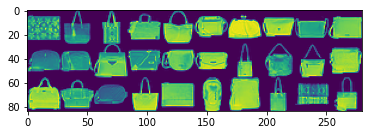

In [7]:
subset = filter_dataset(dataset, lambda target: target == 8)
img = image_dataset_merge(3, 10, subset)
plt.imshow(img)

# Model

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.losses = {}
        self.accuracys = {}
        self.iterations = 0
        
        self.l1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.l2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=10)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.l2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        
        return out
    
    def fit(self, optimizer, error, train_loader):
        for images, labels in train_loader:
            self.iterations += 1

            images, labels = images.to(device), labels.to(device)
            train = Variable(images.view(100, 1, 28, 28))
            #train = Variable(images)
            labels = Variable(labels)

            outputs = self.forward(train)
            loss = error(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            self.loss = loss
            self.losses[self.iterations] = loss.data

    
    def validate(self, val_loader):
        test_list = []
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            val = Variable(images.view(100, 1, 28, 28))
            outputs = self.forward(val)
        
            predictions = torch.max(outputs, 1)[1].to(device)

            test_list.append({
                'y_pred': predictions,
                'y_true': labels,
                'correct': (predictions == labels).sum(),
                'length': len(labels)
            })
        
        correct = sum([t['correct'] for t in test_list])
        total = sum([t['length'] for t in test_list])
        accuracy = correct * 100 / total

        self.accuracys[self.iterations] = accuracy

        return accuracy, test_list

# Optimizers

In [14]:
#Init list for best losses for each configuration.
best_losses = []

## Adam

In [15]:
learning_rates = [0.0001, 0.001, 0.01]
for lr in learning_rates:
    print(f'Training Model with Adam Optimizer of learning rate: {lr}')
    model, best = train_and_save(train_loader, val_loader, opt=Adam, load_model=False, num_epochs=10, learning_rate=lr)
    best_losses.append(best)
    print('-' * 120)

Training Model with Adam Optimizer of learning rate: 0.0001
Epoch[1/10]: Iteration: 500, Loss: 0.40151524543762207, Accuracy: 86.66999816894531
Epoch[2/10]: Iteration: 1000, Loss: 0.24460001289844513, Accuracy: 87.79000091552734
Epoch[3/10]: Iteration: 1500, Loss: 0.2863912284374237, Accuracy: 89.11000061035156
Epoch[4/10]: Iteration: 2000, Loss: 0.2353467047214508, Accuracy: 89.38999938964844
Epoch[5/10]: Iteration: 2500, Loss: 0.2457246631383896, Accuracy: 89.54000091552734
Epoch[6/10]: Iteration: 3000, Loss: 0.2173171490430832, Accuracy: 89.93000030517578
Epoch[7/10]: Iteration: 3500, Loss: 0.3086148798465729, Accuracy: 90.25
Epoch[8/10]: Iteration: 4000, Loss: 0.1883855015039444, Accuracy: 89.97000122070312
Epoch[9/10]: Iteration: 4500, Loss: 0.1386793553829193, Accuracy: 89.93000030517578
Epoch[10/10]: Iteration: 5000, Loss: 0.22445036470890045, Accuracy: 90.3499984741211
--------------------------------------------------------------------------------------------------------------

## SGD

In [16]:
learning_rates = [0.001, 0.01, 0.1]
for lr in learning_rates:
    print(f'Training Model with SGD Optimizer of learning rate: {lr}')
    model, best = train_and_save(train_loader, val_loader, opt=SGD, load_model=False, num_epochs=10, learning_rate=lr)
    best_losses.append(best)
    print('-' * 120)

Training Model with SGD Optimizer of learning rate: 0.001
Epoch[1/10]: Iteration: 500, Loss: 0.7941475510597229, Accuracy: 75.66999816894531
Epoch[2/10]: Iteration: 1000, Loss: 0.6083844900131226, Accuracy: 77.88999938964844
Epoch[3/10]: Iteration: 1500, Loss: 0.4163448214530945, Accuracy: 80.56999969482422
Epoch[4/10]: Iteration: 2000, Loss: 0.5053389072418213, Accuracy: 81.70999908447266
Epoch[5/10]: Iteration: 2500, Loss: 0.5512950420379639, Accuracy: 83.07999420166016
Epoch[6/10]: Iteration: 3000, Loss: 0.46618375182151794, Accuracy: 83.68999481201172
Epoch[7/10]: Iteration: 3500, Loss: 0.33954277634620667, Accuracy: 84.29000091552734
Epoch[8/10]: Iteration: 4000, Loss: 0.42361024022102356, Accuracy: 85.1199951171875
Epoch[9/10]: Iteration: 4500, Loss: 0.4224521517753601, Accuracy: 85.47999572753906
Epoch[10/10]: Iteration: 5000, Loss: 0.3779723644256592, Accuracy: 85.63999938964844
----------------------------------------------------------------------------------------------------

Decide what lossfunction is best for classification

In [23]:
sorted_losses = sorted(best_losses, key=lambda x: x['loss'])
best_loss = sorted_losses[0]
print("Configuration for lowest loss:")
print("-" * 120)
for k, v in best_loss.items():
    print(f'{k}: {v}')
print("-" * 120)
print(f'Best Optimizer is {best_loss["optimizer"]} with the learning rate of {best_loss["learning_rate"]}')

Configuration for lowest loss:
------------------------------------------------------------------------------------------------------------------------
optimizer: Adam
error: CrossEntropyLoss
loss: 0.11415287107229233
iteration: 4500
accuracy: 90.93000030517578
learning_rate: 0.001
------------------------------------------------------------------------------------------------------------------------
Best Optimizer is Adam with the learning rate of 0.001


# Training

In [38]:
model, best = train_and_save(train_loader, val_loader, opt=Adam, load_model=False, model_path='./data/adam-lr-0001.pth',num_epochs=10, learning_rate=best_loss['learning_rate'])

Epoch[1/10]: Iteration: 500, Loss: 0.40502798557281494, Accuracy: 87.88999938964844
Epoch[2/10]: Iteration: 1000, Loss: 0.3458159565925598, Accuracy: 87.94999694824219
Epoch[3/10]: Iteration: 1500, Loss: 0.2565733790397644, Accuracy: 89.6199951171875
Epoch[4/10]: Iteration: 2000, Loss: 0.2331770360469818, Accuracy: 90.68000030517578
Epoch[5/10]: Iteration: 2500, Loss: 0.2279711216688156, Accuracy: 90.22000122070312
Epoch[6/10]: Iteration: 3000, Loss: 0.19207355380058289, Accuracy: 90.22000122070312
Epoch[7/10]: Iteration: 3500, Loss: 0.13748854398727417, Accuracy: 90.6199951171875
Epoch[8/10]: Iteration: 4000, Loss: 0.12968239188194275, Accuracy: 90.81999969482422
Epoch[9/10]: Iteration: 4500, Loss: 0.1796010434627533, Accuracy: 90.97999572753906
Epoch[10/10]: Iteration: 5000, Loss: 0.1442175805568695, Accuracy: 90.90999603271484


## Iterations vs Loss

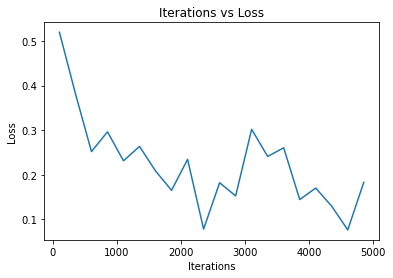

In [40]:
sorted_losses = sorted(model.losses.items(), key=lambda x: x[0])
iterations, losses = zip(*sorted_losses)
iterations = iterations[100:]
np_losses = [loss.cpu().numpy() for loss in losses][100:]

iterations = [n for i, n in enumerate(iterations) if i % 250 == 0]
np_losses = [n for i, n in enumerate(np_losses) if i % 250 == 0]

plt.plot(iterations, np_losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

## Iterations Vs Accuracy

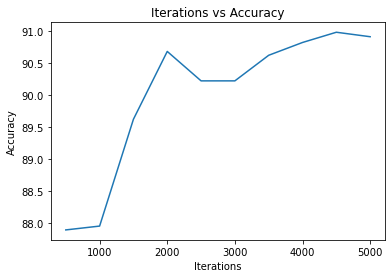

In [41]:
sorted_accuracys = sorted(model.accuracys.items(), key=lambda x: x[0])Epoch[9/14]: Iteration: 4500, Loss: 0.1681900918483734, Accuracy: 90.93000030517578
iterations, accuracys = zip(*sorted_accuracys)
np_accuracys = [a.cpu().numpy() for a in accuracys]
plt.plot(iterations, np_accuracys)

plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

## Confusion Matrix

In [60]:
model = torch.load('./data/adam-lr-0001.pth')
y_pred = []
y_true = []

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    x = Variable(images.view(100, 1, 28, 28))
    outputs = model(x)
    predictions = torch.max(outputs, 1)[1].to(device)

    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predictions.cpu().numpy())


cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)

[[896   1  13  18   1   2  65   0   4   0]
 [  0 983   0  12   1   0   2   0   2   0]
 [ 20   1 875  15  49   2  38   0   0   0]
 [ 28   3   8 925   9   0  27   0   0   0]
 [  2   0  42  34 875   0  45   0   2   0]
 [  0   0   0   1   0 989   0   7   0   3]
 [142   1  56  23  82   0 689   0   7   0]
 [  0   0   0   0   0  27   0 893   1  79]
 [  3   0   2   5   2   1   1   2 984   0]
 [  0   0   1   0   0  10   1   7   0 981]]
